### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging

# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3,
    "use_V_g_profile":False,
    "type": None,
    "B": 20,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 7, 801)          # ship sailing speeds to water, (m/s)
h_0 = [3,3.5,4,5,6,7,8,9,10,20]                 # water depths,(m)
T = [1.7]   # draught


### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(T, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,T,h_0,V_s
8005,1.7,20.0,6.965500
8006,1.7,20.0,6.974125
8007,1.7,20.0,6.982750
8008,1.7,20.0,6.991375
8009,1.7,20.0,7.000000


### Run OpenTNSim to Calculate resistance, required power

In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    
    data_vessel_i = data_vessel.copy()
    
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T']
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    # h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    # print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s, h_0)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    (eta_D, P_propulsion,P_tot,P_given) = vessel.calculate_total_power_required(V_s, h_0)

    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f'] = R_f
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_d'] = P_tot

    results.append(result)

8010it [00:02, 2929.83it/s]


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(50)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,P_d,V_s_km
0,1.7,3.0,0.100000,780.0,0.031502,0.044883,0.003938,3.465372e-164,0.006868,0.055689,49.935911,0.36000
1,1.7,3.0,0.108625,780.0,0.036551,0.052078,0.004569,4.489638e-152,0.008101,0.064748,49.940095,0.39105
2,1.7,3.0,0.117250,780.0,0.041936,0.059750,0.005242,1.161873e-141,0.009436,0.074427,49.944933,0.42210
3,1.7,3.0,0.125875,780.0,0.047650,0.067892,0.005956,1.310748e-132,0.010871,0.084719,49.950468,0.45315
4,1.7,3.0,0.134500,780.0,0.053691,0.076498,0.006711,1.156561e-124,0.012407,0.095617,49.956744,0.48420
5,1.7,3.0,0.143125,780.0,0.060054,0.085564,0.007507,1.247744e-117,0.014044,0.107115,49.963802,0.51525
6,1.7,3.0,0.151750,780.0,0.066736,0.095084,0.008342,2.329557e-111,0.015782,0.119208,49.971685,0.54630
7,1.7,3.0,0.160375,780.0,0.073733,0.105055,0.009217,9.902821e-106,0.017620,0.131892,49.980435,0.57735
8,1.7,3.0,0.169000,780.0,0.081044,0.115471,0.010131,1.193854e-100,0.019559,0.145161,49.990092,0.60840
9,1.7,3.0,0.177625,780.0,0.088665,0.126329,0.011083,4.876548e-96,0.021599,0.159011,50.000698,0.63945


In [9]:
plot_df.tail(25)

,T,h_0,V_s,P_installed,R_f,R_f_one_k1,R_APP,R_W,R_res,R_T,P_d,V_s_km
7985,1.7,20.0,6.793000,780.0,62.671171,89.293378,7.833896,190.415557,30.890698,318.433529,4209.764157,24.45480
7986,1.7,20.0,6.801625,780.0,62.819906,89.505295,7.852488,193.962647,30.945611,322.266041,4265.175314,24.48585
7987,1.7,20.0,6.810250,780.0,62.968806,89.717447,7.871101,197.484228,31.000579,326.073355,4320.383589,24.51690
7988,1.7,20.0,6.818875,780.0,63.117872,89.929834,7.889734,200.969595,31.055601,329.844764,4375.247333,24.54795
7989,1.7,20.0,6.827500,780.0,63.267102,90.142456,7.908388,204.407888,31.110676,333.569408,4429.622185,24.57900
7990,1.7,20.0,6.836125,780.0,63.416497,90.355313,7.927062,207.788170,31.165806,337.236351,4483.362018,24.61005
7991,1.7,20.0,6.844750,780.0,63.566056,90.568404,7.945757,211.099501,31.220988,340.834650,4536.319949,24.64110
7992,1.7,20.0,6.853375,780.0,63.715781,90.781730,7.964473,214.331019,31.276224,344.353445,4588.349408,24.67215
7993,1.7,20.0,6.862000,780.0,63.865670,90.995291,7.983209,217.472024,31.331511,347.782035,4639.305244,24.70320
7994,1.7,20.0,6.870625,780.0,64.015724,91.209087,8.001965,220.512065,31.386851,351.109968,4689.044858,24.73425


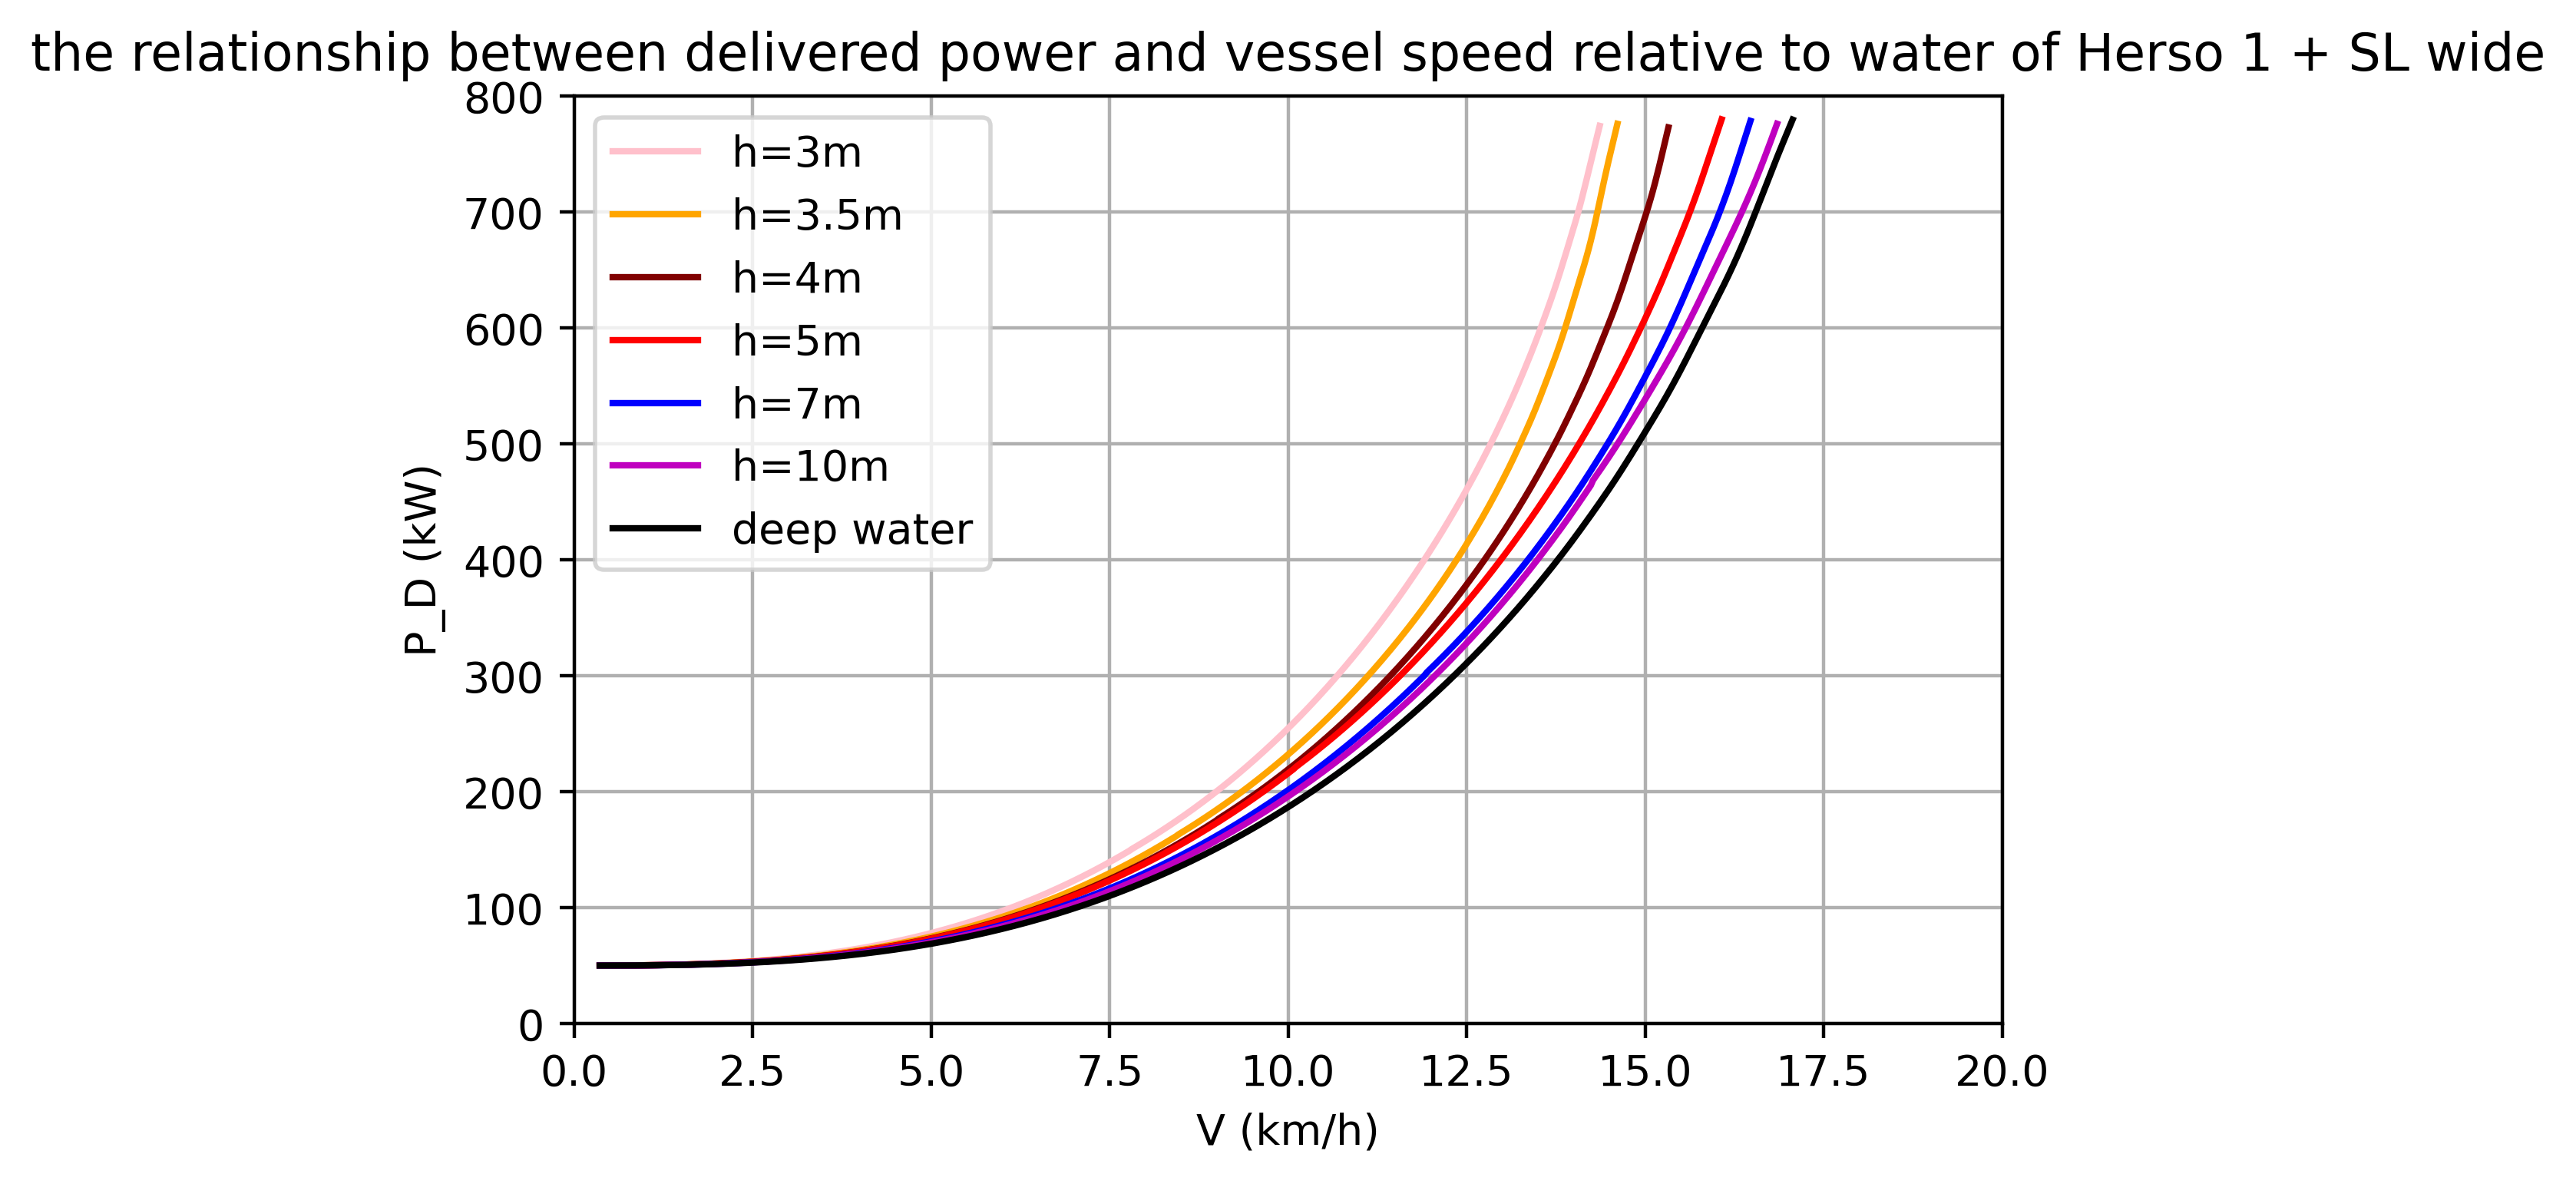

In [10]:
selected_h_3 = plot_df.query('h_0 == 3 & P_d < P_installed')
selected_h_3_5 = plot_df.query('h_0 == 3.5 & P_d < P_installed')
selected_h_4 = plot_df.query('h_0 == 4 & P_d < P_installed')
selected_h_5 = plot_df.query('h_0 == 5 & P_d < P_installed')
selected_h_6 = plot_df.query('h_0 == 6 & P_d < P_installed')
selected_h_7 = plot_df.query('h_0 == 7 & P_d < P_installed')
selected_h_8 = plot_df.query('h_0 == 8 & P_d < P_installed')
selected_h_9 = plot_df.query('h_0 == 9 & P_d < P_installed')
selected_h_10 = plot_df.query('h_0 == 10 & P_d < P_installed')
selected_h_deep = plot_df.query('h_0 == 20 & P_d < P_installed')
plt.figure(dpi=400)
plt.plot(selected_h_3['V_s_km'],selected_h_3['P_d'], 'pink', linewidth = 1.5)
plt.plot(selected_h_3_5['V_s_km'],selected_h_3_5['P_d'], 'orange', linewidth = 1.5)
plt.plot(selected_h_4['V_s_km'],selected_h_4['P_d'], 'maroon', linewidth = 1.5)
plt.plot(selected_h_5['V_s_km'],selected_h_5['P_d'], 'r', linewidth = 1.5)
# plt.plot(selected_h_6['V_s_km'],selected_h_6['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_7['V_s_km'],selected_h_7['P_d'], 'b', linewidth = 1.5)
# plt.plot(selected_h_8['V_s_km'],selected_h_8['P_d'], 'r', linewidth = 1.0)
# plt.plot(selected_h_9['V_s_km'],selected_h_9['P_d'], 'g', linewidth = 1)
plt.plot(selected_h_10['V_s_km'],selected_h_10['P_d'], 'm', linewidth = 1.5)
plt.plot(selected_h_deep['V_s_km'],selected_h_deep['P_d'], 'k', linewidth = 1.5)

plt.xlabel('V (km/h)')
plt.ylabel('P_D (kW)')
plt.legend(['h=3m','h=3.5m','h=4m','h=5m','h=7m','h=10m','deep water'])
plt.grid()
plt.xlim(0, 20)
plt.ylim(0,800)
plt.title('the relationship between delivered power and vessel speed relative to water of Herso 1 + SL wide');